In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from flowanalysis import definitions as fa

import csv
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

plt.rcParams.update({"text.usetex": True})
plt.rcParams["text.latex.preamble"] = r"\usepackage{graphicx}"
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
timeNames = ("Primary", "Memory", "WT challenge", "T8A challege", "N3A challenge")
naiveColumns = ("WT column", "T8A column", "N3A column")
tetramerNames = ("WT", "T8A", "N3A")

# Data formating

For each timepoint and sample the data needs to be formated as a 7-tuple, ordered as follows:
1. WT single positive cells
2. T8A single positive cells
3. WT + T8A double positive cells
4. N3A single positive cells
5. WT + N3A double positive cells
6. T8A + N3A double positive cells
7. WT + T8A + N3A triple positive cells

For each priming infection the data is stored on a list indexed as follows:
1. Mouse
2. Timepoint

If there are fewer mice on one of the timepoints the remaining entries on the list must be (-1, 0, 0, 0, 0, 0, 0) to make sure that the mean is correctly calculated

When reading the data the headers are put in a list ordred as follows:
1. Tissue
2. Timepoint
3. WT single positive cells
4. T8A single positive cells
5. WT + T8A double positive cells
6. N3A single positive cells
7. N3A + WT double positive cells
8. N3A + T8A double positive cells
9. WT + T8A + N3A triple positive cells
10. Total CD8 cells

# Spleen circulating

In [4]:
fa.header_clipping("WT", check=True)
fa.header_clipping("T8A", check=True)
fa.header_clipping("N3A", check=True)

['Mouse', 'Cell_Count', 'Tissue', 'Condition', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8p_Freq', 'CD8p_Norm_Freq', 'CD8p_Num', 'CD8p_N3ATotal_Freq', 'CD8p_N3ATotal_Num', 'CD8p_T8ATotal_Freq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_WTN3ADP_Freq', 'CD8p_WTN3ADP_Num', 'CD8p_WTT8ADP_Freq', 'CD8p_WTT8ADP_Num', 'WTSP_Freq', 'WTSP_Num', 'N3ASP_Freq', 'N3ASP_Num', 'T8ASP_Freq', 'T8ASP_Num']
['Mouse', 'Cell Count', 'Tissue', 'T8A Primary', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8p_Freq', 'CD8p_Norm_Freq', 'CD8p_Num', 'CD8p_N3ATotal_Freq', 'CD8p_N3ATotal_Num', 'CD8p_T8ATotal_Freq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_WTN3ADP_Freq', 'CD8p_WTN3ADP_Num', 'CD8p_WTT8ADP_Freq', 'CD8p_WTT8ADP_Num

In [5]:
fa.header_clipping("WT")
fa.header_clipping("T8A")
fa.header_clipping("N3A")

wt_p_headers = [
    "Tissue",
    "Condition",
    "WTSP_Num",
    "T8ASP_Num",
    "CD8p_WTT8ADP_Num",
    "N3ASP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
t8a_p_headers = [
    "Tissue",
    "T8A Primary",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
n3a_p_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_N3AWTDP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_p_time_names = fa.time_name_list("WT", wt_p_headers)
t8a_p_time_names = fa.time_name_list("T8A", t8a_p_headers)
n3a_p_time_names = fa.time_name_list("N3A", n3a_p_headers)

wt_p_data, wt_p_data_neg = fa.data_extraction(
    "WT", "spleen", wt_p_headers, wt_p_time_names, timepoints=5
)
t8a_p_data, t8a_p_data_neg = fa.data_extraction(
    "T8A", "spleen", t8a_p_headers, t8a_p_time_names, timepoints=5
)
n3a_p_data, n3a_p_data_neg = fa.data_extraction(
    "N3A", "spleen", n3a_p_headers, n3a_p_time_names, timepoints=5
)

In [6]:
fa.venn_plots(
    5,
    wt_p_data,
    timeNames,
    tetramerNames,
    title="Spleen Circulating - WT primary",
    file_name="WT-C",
)

/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")
/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")


In [7]:
fa.venn_plots(
    5,
    t8a_p_data,
    timeNames,
    tetramerNames,
    title="Spleen Circulating - T8A primary",
    file_name="T8A-C",
)

/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")
/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")
/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


In [8]:
fa.venn_plots(
    5,
    n3a_p_data,
    timeNames,
    tetramerNames,
    title="Spleen Circulating - N3A primary",
    file_name="N3A-C",
)

/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")


# Slopes

## Circulating

In [9]:
wt_p_means, wt_p_actual_mice = fa.population_means(wt_p_data)
t8a_p_means, t8a_p_actual_mice = fa.population_means(t8a_p_data)
n3a_p_means, n3a_p_actual_mice = fa.population_means(n3a_p_data)

wt_p_means_neg, wt_p_actual_mice_neg = fa.population_means(wt_p_data_neg)
t8a_p_means_neg, t8a_p_actual_mice_neg = fa.population_means(t8a_p_data_neg)
n3a_p_means_neg, n3a_p_actual_mice_neg = fa.population_means(n3a_p_data_neg)

patch_names = [
    "WT",
    "T8A",
    "N3A",
    "WT+T8A",
    "WT+N3A",
    "T8A+N3A",
    "Triple positive",
    "Triple negative",
]
patch_indices = [0, 1, 3, 2, 4, 5, 6]
times = [10, 70, 90]

In [10]:
fa.slope_plots(
    "Spleen circulating - WT primary",
    wt_p_means,
    wt_p_means_neg,
    times,
    patch_names,
    patch_indices,
    file_name="WT-C-S",
    zeroline=True,
)

In [11]:
fa.slope_plots(
    "Spleen circulating - T8A primary",
    t8a_p_means,
    t8a_p_means_neg,
    times,
    patch_names,
    patch_indices,
    file_name="T8A-C-S",
    zeroline=True,
)

In [12]:
fa.slope_plots(
    "Spleen circulating - N3A primary",
    n3a_p_means,
    n3a_p_means_neg,
    times,
    patch_names,
    patch_indices,
    file_name="N3A-C-S",
    zeroline=True,
)

## Resident

In [13]:
fa.header_clipping("WT", cd45="-", check=True)
fa.header_clipping("T8A", cd45="-", check=True)
fa.header_clipping("N3A", cd45="-", check=True)

['Mouse', 'Cell Count', 'Tissue', 'Condition', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8n_Freq', 'CD8n_Norm_Freq', 'CD8n_Num', 'CD8n_N3ATotal_Freq', 'CD8n_N3ATotal_Num', 'CD8n_T8ATotal_Freq', 'CD8n_T8Atotal_Num', 'CD8n_WTTotal_Freq', 'CD8n_WTTotal_Num', 'CD8n_Triplepos_Freq', 'CD8n_Triplepos_Num', 'CD8n_N3AT8ADP_Freq', 'CD8n_N3AT8ADP_Num', 'CD8n_WTN3ADP_Freq', 'CD8n_WTN3ADP_Num', 'CD8n_WTT8ADP_Freq', 'CD8n_WTT8ADP_Num', 'CD8n_WTSP_Freq', 'CD8n_WTSP_Num', 'CD8n_N3ASP_Freq', 'CD8n_N3ASP_Num', 'CD8n_T8ASP_Freq', 'CD8n_T8ASP_Num', 'Triple Neg', 'total frequency tet+ cells']
['Mouse', 'Cell Count', 'Tissue', 'Infection', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8n_Freq', 'CD8n_Norm_Freq', 'CD8n_Num', 'CD8n_N3A_Total_Freq', 'CD8n_N3A_Total_Num', 'CD8n_T8ATotalFreq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_

In [14]:
fa.header_clipping("WT", cd45="-")
fa.header_clipping("T8A", cd45="-")
fa.header_clipping("N3A", cd45="-")

wt_n_headers = [
    "Tissue",
    "Condition",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTN3ADP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_Triplepos_Num",
    "CD8n_Num",
]
t8a_n_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8n_Num",
]
n3a_n_headers = [
    "Tissue",
    "Infection",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_N3AWTDP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_n_time_names = fa.time_name_list("WT", wt_n_headers, cd45="-")
t8a_n_time_names = fa.time_name_list("T8A", t8a_n_headers, cd45="-")
n3a_n_time_names = fa.time_name_list("N3A", n3a_n_headers, cd45="-")

wt_n_data, wt_n_data_neg = fa.data_extraction(
    "WT", "spleen", wt_n_headers, wt_n_time_names, cd45="-", timepoints=5
)
t8a_n_data, t8a_n_data_neg = fa.data_extraction(
    "T8A", "spleen", t8a_n_headers, t8a_n_time_names, cd45="-", timepoints=5
)
n3a_n_data, n3a_n_data_neg = fa.data_extraction(
    "N3A", "spleen", n3a_n_headers, n3a_n_time_names, cd45="-", timepoints=5
)

wt_n_means, wt_n_actual_mice = fa.population_means(wt_n_data)
t8a_n_means, t8a_n_actual_mice = fa.population_means(t8a_n_data)
n3a_n_means, n3a_n_actual_mice = fa.population_means(n3a_n_data)

wt_n_means_neg, wt_n_actual_mice_neg = fa.population_means(wt_n_data_neg)
t8a_n_means_neg, t8a_n_actual_mice_neg = fa.population_means(t8a_n_data_neg)
n3a_n_means_neg, n3a_n_actual_mice_neg = fa.population_means(n3a_n_data_neg)

In [15]:
fa.slope_plots(
    "Spleen resident - WT primary",
    wt_n_means,
    wt_n_means_neg,
    times,
    patch_names,
    patch_indices,
    file_name="WT-R-S",
    zeroline=True,
)

In [16]:
fa.slope_plots(
    "Spleen resident - T8A primary",
    t8a_n_means,
    t8a_n_means_neg,
    times,
    patch_names,
    patch_indices,
    file_name="T8A-R-S",
    zeroline=True,
)

In [17]:
fa.slope_plots(
    "Spleen resident - N3A primary",
    n3a_n_means,
    n3a_n_means_neg,
    times,
    patch_names,
    patch_indices,
    file_name="N3A-R-S",
    zeroline=True,
)

In [18]:
fa.venn_plots(
    5,
    wt_n_data,
    timeNames,
    tetramerNames,
    title="Spleen resident - WT primary",
    file_name="WT-R",
)

In [19]:
fa.venn_plots(
    5,
    t8a_n_data,
    timeNames,
    tetramerNames,
    title="Spleen resident - T8A primary",
    file_name="T8A-R",
)

In [20]:
fa.venn_plots(
    5,
    n3a_n_data,
    timeNames,
    tetramerNames,
    title="Spleen resident - N3A primary",
    file_name="N3A-R",
)

# Naive tests

In [21]:
fa.header_clipping("Naive", check=True)

['Mouse', 'Tissue', 'Cell Count', 'Experiment', 'Stain for Column Selection', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'B220 F480 Neg', 'CD8_Freq', 'CD8_Num', 'CD8_N3ATotal_Freq', 'CD8_N3ATotal_Num', 'CD8_T8ATotal_Freq', 'CD8_T8ATotal_Num', 'CD8_WTTotal_Freq', 'CD8_WTTotal_Num', 'N3A Neg', 'T8A Neg', 'WT Neg', 'CD8_TriplePos_Freq', 'CD8_TriplePos_Num', 'CD8_N3AT8ADP_Freq', 'CD8_N3AT8ADP_Num', 'CD8_WTN3ADP_Freq', 'CD8_WTN3ADP_Num', 'CD8_N3ASP_Freq', 'CD8_N3ASP_Num', 'CD8_WTT8ADP_Freq', 'CD8_WTT8ADP_Num', 'CD8_T8ASP_Freq', 'CD8_T8ASP_Num', 'CD8_WTSP_Freq', 'CD8_WTSP_Num', 'CD8_TripleNeg_Freq', 'CD8_TripleNeg_Num']


In [22]:
fa.header_clipping("Naive")

naive_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_WTSP_Num",
    "CD8_T8ASP_Num",
    "CD8_WTT8ADP_Num",
    "CD8_N3ASP_Num",
    "CD8_WTN3ADP_Num",
    "CD8_N3AT8ADP_Num",
    "CD8_TriplePos_Num",
    "CD8_Num",
]

naive_column_names = fa.time_name_list("Naive", naive_headers)

naive_data, naive_data_neg = fa.data_extraction(
    "Naive", "Spleen + Lymphnodes", naive_headers, naive_column_names
)

naive_means, naive_actual_mice = fa.population_means(naive_data)

naive_means_neg, naive_actual_mice_neg = fa.population_means(naive_data_neg)

In [23]:
fa.venn_plots(
    3,
    naive_data,
    naiveColumns,
    tetramerNames,
    title="Naive data",
    file_name="Naive-Venn",
    # ignore=[0, 4],
)

In [24]:
fa.header_clipping("Naive", filename="WT", check=True)
fa.header_clipping("Naive", filename="T8A", check=True)
fa.header_clipping("Naive", filename="N3A", check=True)

['Mouse', 'Tissue', 'Cell Count', 'Experiment', 'Stain for Column Selection', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'B220 F480 Neg', 'CD8_Freq', 'CD8_Num', 'Column Selected WT Positive_Freq', 'Column Selected WT Positive_Num', 'CD8_WT_N3ATotal_Freq', 'CD8_WT_N3ATotal_Num', 'CD8_WT_T8ATotal_Freq', 'CD8_WT_T8ATotal_Num', 'CD8_WT_N3Aneg_Freq', 'CD8_WT_N3Aneg_Num', 'CD8_WT_T8Aneg_Freq', 'CD8_WT_T8Aneg_Num', 'CD8_WT_N3AT8ADP_Freq', 'CD8_WT_N3AT8ADP_Num', 'CD8_WT_N3ASP_Freq', 'CD8_WT_N3ASP_Num', 'CD8_WT_T8ASP_Freq', 'CD8_WT_T8ASP_Num', 'CD8_WT_N3AT8Aneg_Freq', 'CD8_WT_N3AT8Aneg_Num']
['Mouse', 'Tissue', 'Cell Count', 'Experiment', 'Stain for Column Selection', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'B220 F480 Neg', 'CD8_Freq', 'CD8_Num', 'Column Selected T8A Positive_Freq', 'Column Selected T8A Positive_Num', 'CD8_T8A_N3ATotal_Freq', 'CD8_T8A_N3ATotal_Num', 'CD8_T8A_WTTotal_Freq', 'CD8_T8A_WTTotal_Num', 'CD8_T8A_N3Aneg_Freq', 'CD8_T8A_N3Aneg_Num', 'CD8_T8A_WTneg_Fr

In [25]:
fa.header_clipping("Naive", filename="WT")
fa.header_clipping("Naive", filename="T8A")
fa.header_clipping("Naive", filename="N3A")

naive_wt_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_WT_N3AT8Aneg_Num",
    "CD8_WT_T8ASP_Num",
    "CD8_WT_N3ASP_Num",
    "CD8_WT_N3AT8ADP_Num",
    "Column Selected WT Positive_Num",
]

naive_t8a_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_T8A_N3AWTneg_Num",
    "CD8_T8A_WTSP_Num",
    "CD8_T8A_N3ASP_Num",
    "CD8_T8A_N3AWTDP_Num",
    "Column Selected T8A Positive_Num",
]

naive_n3a_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_N3A_WTT8Aneg_Num",
    "CD8_N3A_WTSP_Num",
    "CD8_N3A_T8ASP_Num",
    "CD8_N3A_T8AWTDP_Num",
    "Column Selected N3A Positive_Num",
]

naive_wt_column_names = fa.time_name_list("Naive", naive_wt_headers, filename="WT")
naive_t8a_column_names = fa.time_name_list("Naive", naive_t8a_headers, filename="T8A")
naive_n3a_column_names = fa.time_name_list("Naive", naive_n3a_headers, filename="N3A")

naive_wt_data, naive_wt_data_neg = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_wt_headers,
    naive_wt_column_names,
    data_type="naive",
    column="WT",
    filename="WT",
)

naive_t8a_data, naive_t8a_data_neg = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_t8a_headers,
    naive_t8a_column_names,
    data_type="naive",
    column="T8A",
    filename="T8A",
)

naive_n3a_data, naive_n3a_data_neg = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_n3a_headers,
    naive_n3a_column_names,
    data_type="naive",
    column="N3A",
    filename="N3A",
)

In [26]:
naive_wt_data

[[(6520, 0, 67400, 0, 8690, 0, 28300)],
 [(5810, 0, 2080, 0, 1790, 0, 0)],
 [(0, 0, 1560, 0, 3130, 0, 3910)],
 [(1130, 0, 11300, 0, 1690, 0, 3390)],
 [(820, 0, 2870, 0, 820, 0, 1230)]]

In [27]:
naive_t8a_data

[[(0, 292, 0, 0, 0, 0, 0)],
 [(0, 6830, 727, 0, 0, 1020, 146)],
 [(0, 2330, 0, 0, 0, 1550, 6210)],
 [(0, 581, 4070, 0, 0, 581, 11000)],
 [(0, 1720, 3860, 0, 0, 858, 3430)]]

In [28]:
naive_n3a_data

[[(0, 0, 0, 513, 257, 257, 0)],
 [(0, 0, 0, 3030, 2210, 814, 117)],
 [(0, 0, 0, 1140, 0, 2050, 1140)],
 [(0, 0, 0, 535, 3740, 1070, 0)],
 [(0, 0, 0, 887, 3100, 0, 443)]]

In [29]:
combined_naive_data = fa.combine_naive_data(
    [naive_wt_data, naive_t8a_data, naive_n3a_data]
)

In [30]:
combined_naive_data

[[(6520, 0, 67400, 0, 8690, 0, 28300),
  (0, 292, 0, 0, 0, 0, 0),
  (0, 0, 0, 513, 257, 257, 0)],
 [(5810, 0, 2080, 0, 1790, 0, 0),
  (0, 6830, 727, 0, 0, 1020, 146),
  (0, 0, 0, 3030, 2210, 814, 117)],
 [(0, 0, 1560, 0, 3130, 0, 3910),
  (0, 2330, 0, 0, 0, 1550, 6210),
  (0, 0, 0, 1140, 0, 2050, 1140)],
 [(1130, 0, 11300, 0, 1690, 0, 3390),
  (0, 581, 4070, 0, 0, 581, 11000),
  (0, 0, 0, 535, 3740, 1070, 0)],
 [(820, 0, 2870, 0, 820, 0, 1230),
  (0, 1720, 3860, 0, 0, 858, 3430),
  (0, 0, 0, 887, 3100, 0, 443)]]

In [31]:
naive_column_names = [
    "SP [WT]",
    "T8A [WT]",
    "N3A [WT]",
    "TP [WT]",
    "SP [T8A]",
    "WT [T8A]",
    "N3A [T8A]",
    "TP [T8A]",
    "SP [N3A]",
    "WT [N3A]",
    "T8A [N3A]",
    "TP [N3A]",
]

statsDF = fa.stats_dataframe(combined_naive_data, naive_column_names)

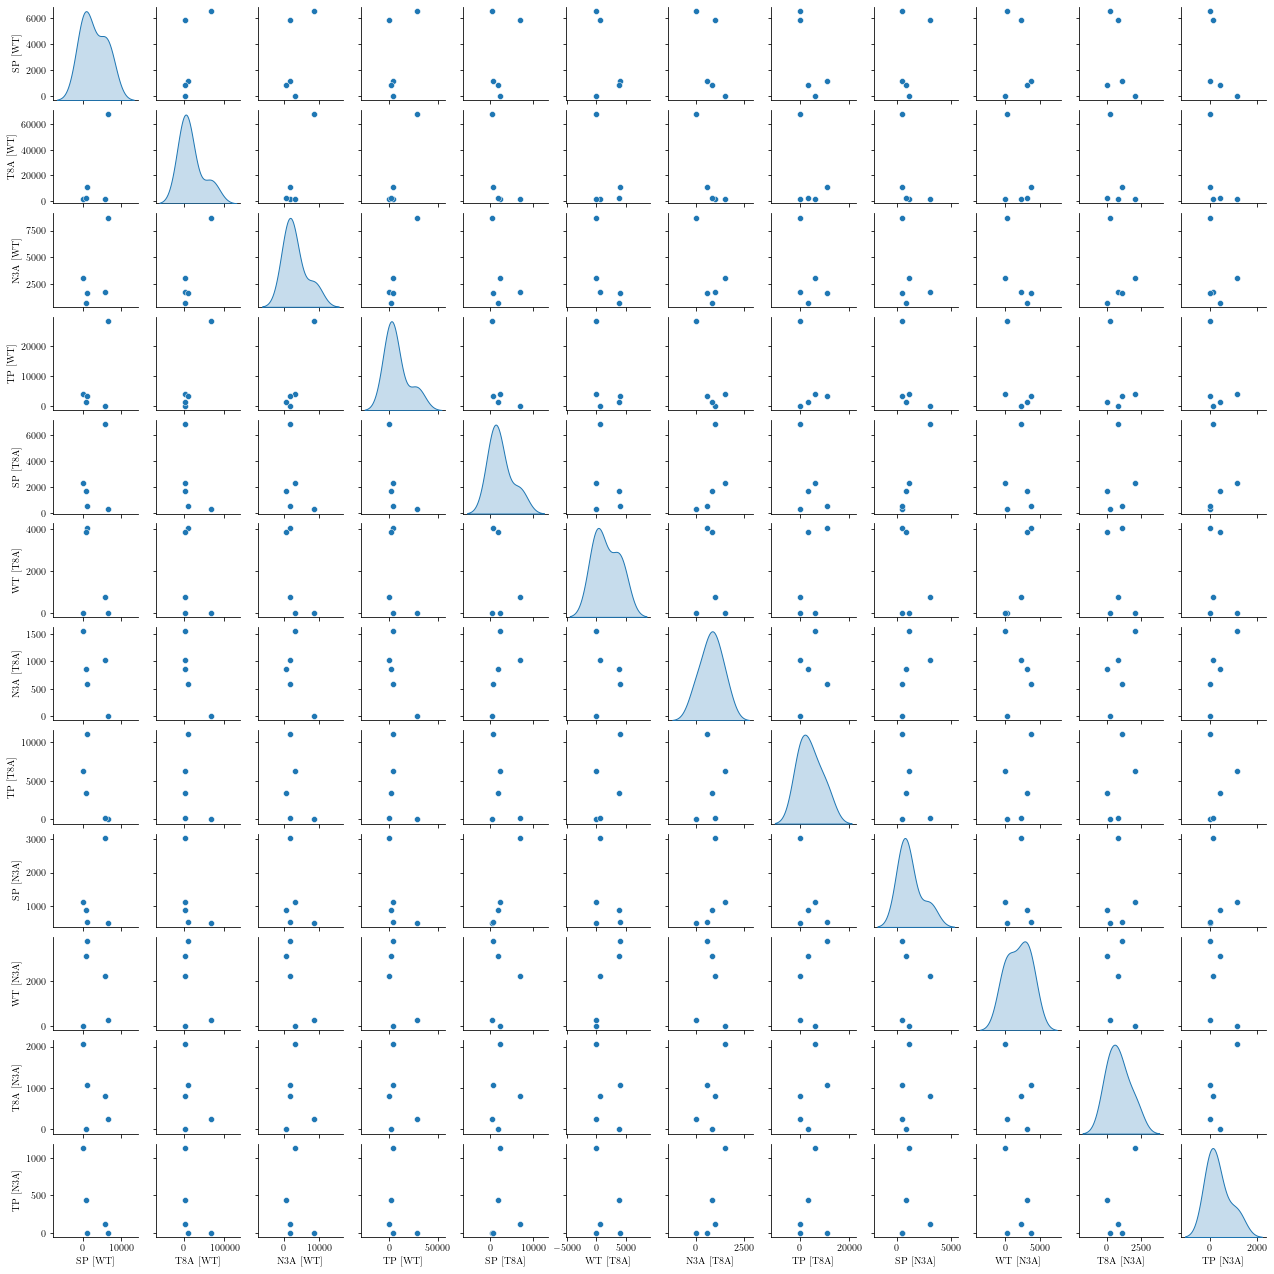

In [32]:
sns.pairplot(statsDF, diag_kind="kde", height=1.5)

In [63]:
def pairs_stats(x, y, **kwargs):

    corr, pvalue = stats.pearsonr(x, y)
    corr_size = 15 + (1 - pvalue) * 15
    ast = ""
    if pvalue <= 0.05 / 66:  # 12 choose 2
        ast = "\\ast"
    elif pvalue <= 0.01 / 66:
        ast = "\\ast\\ast"

    ax = plt.gca()
    ax.set_axis_off()
    ax.annotate(
        f"${corr:.3f}{ast}$",
        xy=(0.5, 0.5),
        xycoords=ax.transAxes,
        ha="center",
        fontsize=corr_size,
    )
    # ax.annotate(f"$p={pvalue:.4f}$", xy=(0.5, 0.3), xycoords=ax.transAxes, ha='center', fontsize=10)

In [65]:
grid = sns.PairGrid(data=statsDF, height=1.5, diag_sharey=False)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.scatterplot)
grid.map_upper(pairs_stats)
grid.figure.savefig("Naive-stats.pdf")
plt.close("all")
# grid.tight_layout()

In [36]:
fa.venn_plots(
    3,
    combined_naive_data,
    naiveColumns,
    tetramerNames,
    title="Naive data",
    file_name="Naive",
    # ignore=[0, 4],
)

/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")
/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


# Plotly tests

## Plots

In [37]:
data = [
    wt_p_data,
    t8a_p_data,
    n3a_p_data,
    wt_p_data_neg,
    t8a_p_data_neg,
    n3a_p_data_neg,
]
priming = ["WT", "T8A", "N3A"]
time = [10, 70, 90, 90, 90]
organ = ["Spleen", "Spleen", "Spleen"]
cd45 = ["-", "-", "-"]
columns = ["Organ", "CD45", "Priming", "Time (dpi)", "Cells", "Tetramer", "Timepoint"]
infection_dict = {0: "Primary", 1: "Memory", 2: "WT", 3: "T8A", 4: "N3A"}
patch_dict = {
    0: "WT",
    1: "T8A",
    3: "N3A",
    2: "WT+T8A",
    4: "WT+N3A",
    5: "T8A+N3A",
    6: "Triple positive",
}

dataDF = fa.plot_dataframe(
    data, priming, time, organ, cd45, columns, patch_dict, infection_dict
)

In [38]:
fig = px.line(
    dataDF[
        (dataDF.Timepoint == "Primary")
        | (dataDF.Timepoint == "Memory")
        | (dataDF.Timepoint == "WT")
    ],
    x="Time (dpi)",
    y="Cells",
    color="Tetramer",
    title="Contration and expansion slopes",
    markers=True,
    log_y=False  # ,
    # symbol='Priming'
)

# fig.show()

fig.write_html("single-slope-plot.html")

In [39]:
dataDF[
    (dataDF.Timepoint == "WT")
    | (dataDF.Timepoint == "T8A")
    | (dataDF.Timepoint == "N3A")
]

,Organ,CD45,Priming,Time (dpi),Cells,Tetramer,Timepoint
14,Spleen,-,WT,90,1057312.00,WT,WT
15,Spleen,-,WT,90,32473.25,T8A,WT
16,Spleen,-,WT,90,1130300.00,WT+T8A,WT
17,Spleen,-,WT,90,1815.00,N3A,WT
18,Spleen,-,WT,90,11830.00,WT+N3A,WT
...,...,...,...,...,...,...,...
113,Spleen,-,T8A,90,15082000.00,Total,T8A
114,Spleen,-,T8A,90,7268000.00,Total,N3A
117,Spleen,-,N3A,90,27266666.33,Total,WT
118,Spleen,-,N3A,90,4512500.00,Total,T8A


In [40]:
dataDF[
    (dataDF.Timepoint == "WT")
    | (dataDF.Timepoint == "T8A")
    | (dataDF.Timepoint == "N3A")
].pivot(columns="Tetramer").stack()

,,Organ,CD45,Priming,Time (dpi),Cells,Timepoint
,Tetramer,,,,,,
14,WT,Spleen,-,WT,90.0,1057312.00,WT
15,T8A,Spleen,-,WT,90.0,32473.25,WT
16,WT+T8A,Spleen,-,WT,90.0,1130300.00,WT
17,N3A,Spleen,-,WT,90.0,1815.00,WT
18,WT+N3A,Spleen,-,WT,90.0,11830.00,WT
...,...,...,...,...,...,...,...
113,Total,Spleen,-,T8A,90.0,15082000.00,T8A
114,Total,Spleen,-,T8A,90.0,7268000.00,N3A
117,Total,Spleen,-,N3A,90.0,27266666.33,WT


In [41]:
dataDF.head()

,Organ,CD45,Priming,Time (dpi),Cells,Tetramer,Timepoint
0,Spleen,-,WT,10,43259.8,WT,Primary
1,Spleen,-,WT,10,18044.0,T8A,Primary
2,Spleen,-,WT,10,13820.0,WT+T8A,Primary
3,Spleen,-,WT,10,333.8,N3A,Primary
4,Spleen,-,WT,10,12228.0,WT+N3A,Primary


## Multi-col test

In [42]:
times = [10, 70, 90]
left_col = [0, 1, 2, 6, 7, 8, 12, 13, 14]
right_col = [3, 4, 5, 9, 10, 11, 15, 16, 17]
colours = ["#29e0c3", "#f28b2e", "#34a0e0"]
tetramers = ["WT", "T8A", "N3A"]

fig = go.Figure().set_subplots(
    rows=3,
    cols=2,
    subplot_titles=(
        "WT primary",
        "WT primary",
        "T8A primary",
        "T8A primary",
        "N3A primary",
        "N3A primary",
    ),
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.05,
)

fig.update_layout(
    legend_title_text="Challenge infection",
    legend=dict(
        yanchor="bottom",
        xanchor="center",
        y=1.02,
        x=0.5,
        orientation="h",
        font={"size": 18},
    ),
    height=1200,
    width=750,
)

fig.update_xaxes(title_text="Time (dpi)", row=3, col=1)
fig.update_xaxes(title_text="Time (dpi)", row=3, col=2)
fig.update_xaxes(tickvals=[10, 70, 90], title_font={"size": 14})
fig.update_yaxes(title_text="Cells", title_font={"size": 14}, col=1)
# fig.update_yaxes(type='log')
# , rangemode='nonnegative')


# WT primary

# Left column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "WT", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            line=dict(color=colours[colour]),
        ),
        1,
        1,
    )


# Right column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "WT", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        1,
        2,
    )

# SEPARATE INTO ONE LINE FOR FIRST CONTRACTION AND 3 LINES FOR EXPASIONS


# T8A primary

# Left column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "T8A", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        2,
        1,
    )

# Right column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "T8A", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        2,
        2,
    )

# SEPARATE INTO ONE LINE FOR FIRST CONTRACTION AND 3 LINES FOR EXPASIONS


# N3A primary

# Left column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "N3A", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        3,
        1,
    )

# Right column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "N3A", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        3,
        2,
    )

# SEPARATE INTO ONE LINE FOR FIRST CONTRACTION AND 3 LINES FOR EXPASIONS

fig.update_layout(
    updatemenus=[
        dict(
            # type="buttons",  # Remove for dropdown
            direction="down",  # down if dropdown, right if buttons
            x=0.25,
            y=1.06,
            showactive=True,
            xanchor="center",
            yanchor="bottom",
            buttons=list(
                [
                    dict(
                        label="WT",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT")}, left_col],
                    ),
                    dict(
                        label="T8A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "T8A")}, left_col],
                    ),
                    dict(
                        label="N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "N3A")}, left_col],
                    ),
                    dict(
                        label="WT+T8A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT+T8A")}, left_col],
                    ),
                    dict(
                        label="WT+N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT+N3A")}, left_col],
                    ),
                    dict(
                        label="T8A+N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "T8A+N3A")}, left_col],
                    ),
                    dict(
                        label="Triple positive",
                        method="restyle",
                        args=[
                            {"y": fa.data_update(dataDF, "Triple positive")},
                            left_col,
                        ],
                    ),
                    dict(
                        label="Triple negative",
                        method="restyle",
                        args=[
                            {"y": fa.data_update(dataDF, "Triple negative")},
                            left_col,
                        ],
                    ),
                    dict(
                        label="Total",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "Total")}, left_col],
                    ),
                ]
            ),
        ),
        dict(
            direction="down",
            x=0.75,
            y=1.06,
            showactive=True,
            xanchor="center",
            yanchor="bottom",
            buttons=list(
                [
                    dict(
                        label="WT",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT")}, right_col],
                    ),
                    dict(
                        label="T8A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "T8A")}, right_col],
                    ),
                    dict(
                        label="N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "N3A")}, right_col],
                    ),
                    dict(
                        label="WT+T8A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT+T8A")}, right_col],
                    ),
                    dict(
                        label="WT+N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT+N3A")}, right_col],
                    ),
                    dict(
                        label="T8A+N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "T8A+N3A")}, right_col],
                    ),
                    dict(
                        label="Triple positive",
                        method="restyle",
                        args=[
                            {"y": fa.data_update(dataDF, "Triple positive")},
                            right_col,
                        ],
                    ),
                    dict(
                        label="Triple negative",
                        method="restyle",
                        args=[
                            {"y": fa.data_update(dataDF, "Triple negative")},
                            right_col,
                        ],
                    ),
                    dict(
                        label="Total",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "Total")}, right_col],
                    ),
                ]
            ),
        ),
    ]
)

# fig.show()

fig.write_html("slope-plots.html")

In [43]:
def data_test(positive_data, total_data):
    print(
        f"{'Mouse' : ^9}{'Time' : ^8}{'Positive' : ^12}{'Total' : ^12}{'Fraction' : ^12}{'Correct' : ^11}"
    )
    print("=" * 64)
    for mouse in range(len(positive_data)):
        for current_time in range(len(positive_data[mouse])):
            print(
                f"{mouse + 1 : ^9}{current_time + 1 : ^8}{sum(positive_data[mouse][current_time]) : ^12}{total_data[mouse][current_time][0] : ^12}{round(sum(positive_data[mouse][current_time]) / total_data[mouse][current_time][0], 5) : ^12}{sum(positive_data[mouse][current_time]) <= total_data[mouse][current_time][0] : ^11}"
            )

In [44]:
data_test(n3a_p_data, n3a_p_data_neg)

  Mouse    Time    Positive     Total      Fraction    Correct  
    1       1       84100      4190000     0.02007        1     
    1       2       16790       994000     0.01689        1     
    1       3      9128700     26700000     0.3419        1     
    1       4       125767     6060000     0.02075        1     
    1       5      7558420     27900000    0.27091        1     
    2       1       229240     7150000     0.03206        1     
    2       2       56730      6030000     0.00941        1     
    2       3      16179440    42800000    0.37802        1     
    2       4       141180     4450000     0.03173        1     
    2       5       501620     2640000     0.19001        1     
    3       1       89800      4880000      0.0184        1     
    3       2       64640      7180000      0.009         1     
    3       3      4755630     12300000    0.38664        1     
    3       4       303210     5470000     0.05543        1     
    3       5      100720